# Machine Learning Project
## Asteroid Classification

### Import the libraries

In [1]:
from sklearn.inspection import permutation_importance
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn import tree
from IPython import display
# !pip install graphviz
import graphviz
from sklearn.tree import plot_tree

### Import the Dataset

In [6]:
df= pd.read_csv("asteroid_dataset.csv") #we imported the dataset

Let's have a look at the column names

column_headers = list(df.columns.values)
column_headers #

And at isolate the target variable

In [8]:
target= df.iloc[:,-1]
target

0        True
1       False
2        True
3       False
4        True
        ...  
4682    False
4683    False
4684    False
4685    False
4686    False
Name: Hazardous, Length: 4687, dtype: bool

### Clean the dataset


In [9]:
# Dropping the columns withe distances in miles
df1=df.drop(['Est Dia in Miles(min)', 'Est Dia in Miles(max)','Est Dia in M(min)','Est Dia in M(max)','Est Dia in Feet(min)','Est Dia in Feet(max)','Relative Velocity km per hr','Miles per hour','Miss Dist.(miles)'], axis=1)                                       

In [10]:
# Checking for NAs
df.isnull().sum().sum()

0

In [14]:
ob=list(df['Orbiting Body'])
Body=0
for o in ob:
    if o =='Earth':
        Body+=1
        
Body

4687

Orbiting body is the same far all the observations

In [15]:
# Checking for duplicates 
a=list(df.duplicated(keep=False))
duplicates=0
for i in a :
    if i==True:
        duplicates=duplicates+1
        
duplicates

0

No duplicates found

In [16]:
# Now checking if the same object appears multiple times in the df

b=list(df1.duplicated(subset= ['Neo Reference ID'],keep=False))       
repeated_id=0
for l in b :
    if l==True:
        repeated_id=repeated_id+1
        
repeated_id


1746

Some objects are repeating but this means only that multiple observations have been made of the same object. 
This can be proved by the fact that there are no duplicates found, thus each rown is differnt. 
If an id appears twice or more it means that it has been recorded different times.

### Feature Engineering

Not all variables are expressed in the same unit of measure so we will cast the ones that are reffered to a distance into AU


In [17]:
miss_dist_from_moon_au= df1['Miss Dist.(lunar)'] * 0.0025695686589742 
    
miss_dist_from_earth_au=(df['Miss Dist.(kilometers)']) * 6.684587122671e-9

df2=df1.drop(['Miss Dist.(lunar)', 'Miss Dist.(kilometers)'], axis=1)      
df2['Miss Dist. moon (au)']=miss_dist_from_moon_au
df2['Miss Dist. earth (au)']= miss_dist_from_earth_au


Check for corerlations 

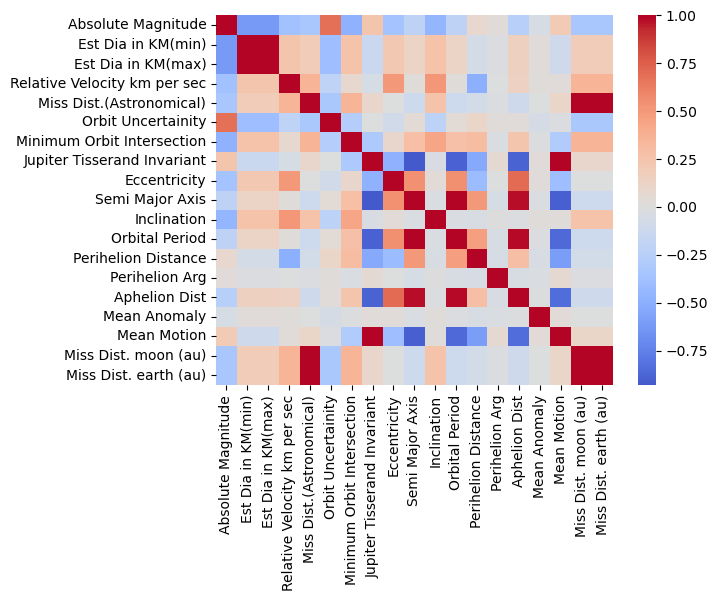

In [19]:
cor_df = df2.drop (['Neo Reference ID','Name','Perihelion Time','Asc Node Longitude','Epoch Date Close Approach','Epoch Osculation','Close Approach Date','Orbit Determination Date','Orbiting Body','Orbit ID','Equinox','Hazardous'], axis =1)
column_headers2 = list(cor_df.columns.values)
cor = cor_df.corr()
sns.heatmap(cor,cmap='coolwarm', center=0)
plt.show()

Analyze some meaningful correlations

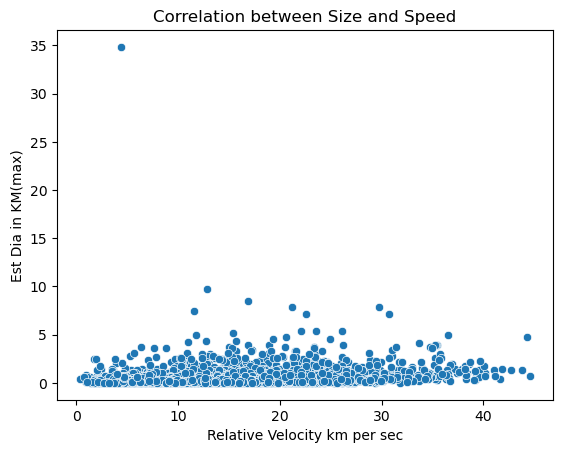

The correlation between Relative Velocity km per sec and Est Dia in KM(max) is 0.24214074876370464


In [28]:
# Check the correlation between size and speed
vd_corr= cor_df['Relative Velocity km per sec'].corr(cor_df['Est Dia in KM(max)'])
sns.scatterplot(x='Relative Velocity km per sec', y='Est Dia in KM(max)', data=cor_df)
plt.title('Correlation between Size and Speed')
plt.show()
print(f'The correlation between Relative Velocity km per sec and Est Dia in KM(max) is {vd_corr}')


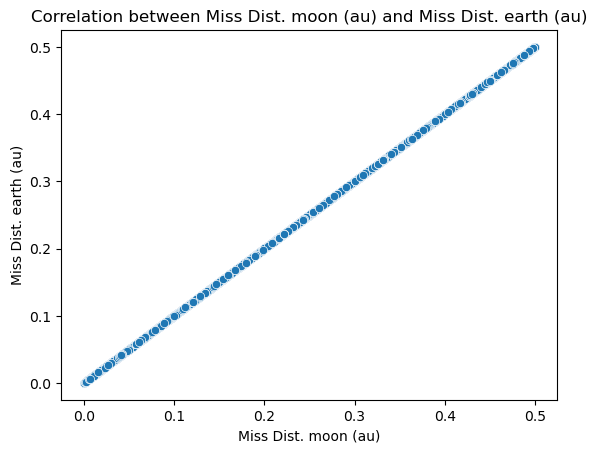

The correlation between Miss Dist. moon (au) and Miss Dist. earth (au) 0.9999999999999971


In [29]:

me_corr= cor_df['Miss Dist. moon (au)'].corr(cor_df['Miss Dist. earth (au)'])
sns.scatterplot(x='Miss Dist. moon (au)', y='Miss Dist. earth (au)', data=cor_df)
plt.title('Correlation between Miss Dist. moon (au) and Miss Dist. earth (au)')
plt.show()
print(f'The correlation between Miss Dist. moon (au) and Miss Dist. earth (au) {me_corr}')



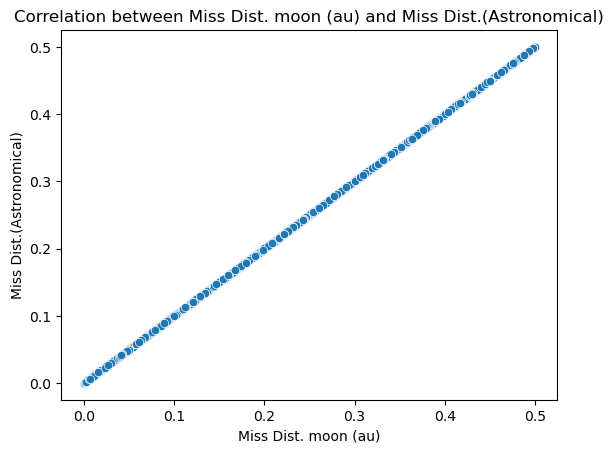

The correlation between Miss Dist. moon (au) km per sec and Miss Dist.(Astronomical) is 0.9999999999999979


In [30]:

mm_corr= cor_df['Miss Dist. moon (au)'].corr(cor_df['Miss Dist.(Astronomical)'])
sns.scatterplot(x='Miss Dist. moon (au)', y='Miss Dist.(Astronomical)', data=cor_df)
plt.title('Correlation between Miss Dist. moon (au) and Miss Dist.(Astronomical)')
plt.show()
print(f'The correlation between Miss Dist. moon (au) km per sec and Miss Dist.(Astronomical) is {mm_corr}')
#thus we will us only Miss Dist.(Astronomical)


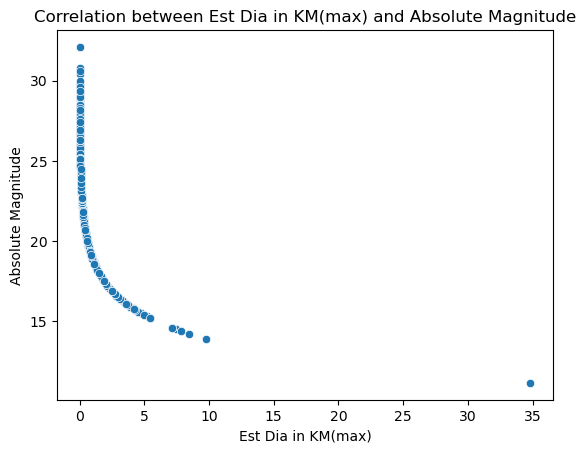

The correlation between Est Dia in KM(max)and Absolute Magnitude -0.6134815101560878


In [31]:

md_corr= cor_df['Est Dia in KM(max)'].corr(cor_df['Absolute Magnitude'])
sns.scatterplot(x='Est Dia in KM(max)', y='Absolute Magnitude', data=cor_df)
plt.title('Correlation between Est Dia in KM(max) and Absolute Magnitude')
plt.show()
print(f'The correlation between Est Dia in KM(max)and Absolute Magnitude {md_corr}')
# seems like the less size the more brightness STRANO


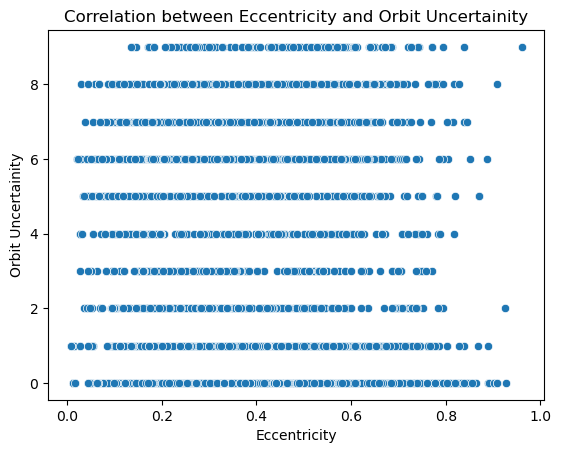

The correlation between Eccentricity and Orbit Uncertainityis -0.0880294783953073


In [32]:

eu_corr= cor_df['Eccentricity'].corr(cor_df['Orbit Uncertainity'])
sns.scatterplot(x='Eccentricity', y='Orbit Uncertainity', data=cor_df)
plt.title('Correlation between Eccentricity and Orbit Uncertainity')
plt.show()
print(f'The correlation between Eccentricity and Orbit Uncertainityis {eu_corr}')
# no correlation


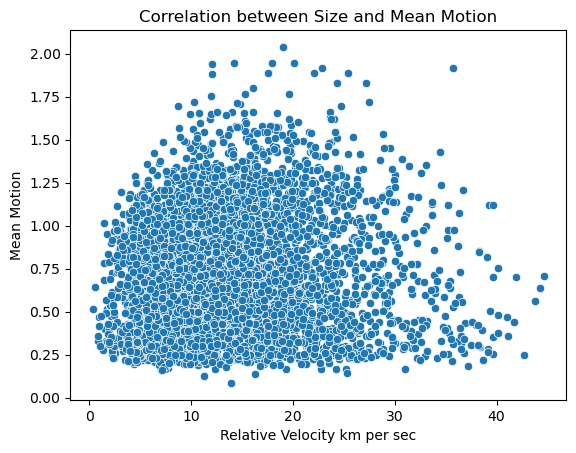

The correlation between Relative Velocity km per sec and Mean Motionis 0.02245246596191886


In [33]:

vm_corr= cor_df['Relative Velocity km per sec'].corr(cor_df['Mean Motion'])
sns.scatterplot(x='Relative Velocity km per sec', y='Mean Motion', data=cor_df)
plt.title('Correlation between Size and Mean Motion')
plt.show()
print(f'The correlation between Relative Velocity km per sec and Mean Motionis {vm_corr}')
#no corr


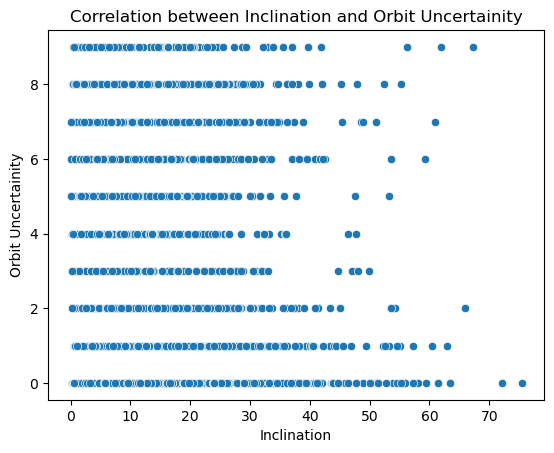

The correlation between Inclination and Orbit Uncertainityis -0.22880574113550484


In [34]:

iu_corr= cor_df['Inclination'].corr(cor_df['Orbit Uncertainity'])
sns.scatterplot(x='Inclination', y='Orbit Uncertainity', data=cor_df)
plt.title('Correlation between Inclination and Orbit Uncertainity')
plt.show()
print(f'The correlation between Inclination and Orbit Uncertainityis {iu_corr}')
# no correlation


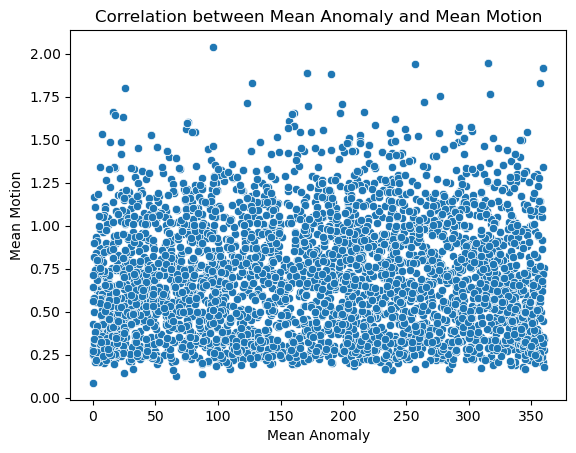

The correlation between Mean Anomaly and Mean Motionis 0.03584929839083319


In [35]:

am_corr= cor_df['Mean Anomaly'].corr(cor_df['Mean Motion'])
sns.scatterplot(x='Mean Anomaly', y='Mean Motion', data=cor_df)
plt.title('Correlation between Mean Anomaly and Mean Motion')
plt.show()
print(f'The correlation between Mean Anomaly and Mean Motionis {am_corr}')
#no corr

### Distriubtion analysis

In [24]:
# Derving distribution info
tt=cor_df.describe()
print(tt)

       Absolute Magnitude  Est Dia in KM(min)  Est Dia in KM(max)  \
count         4687.000000         4687.000000         4687.000000   
mean            22.267865            0.204604            0.457509   
std              2.890972            0.369573            0.826391   
min             11.160000            0.001011            0.002260   
25%             20.100000            0.033462            0.074824   
50%             21.900000            0.110804            0.247765   
75%             24.500000            0.253837            0.567597   
max             32.100000           15.579552           34.836938   

       Relative Velocity km per sec  Miss Dist.(Astronomical)  \
count                   4687.000000               4687.000000   
mean                      13.970811                  0.256778   
std                        7.293223                  0.145798   
min                        0.335504                  0.000178   
25%                        8.432865                  

/var/folders/_t/_dykrs9j7ks2wb38v85_lw7m0000gn/T/ipykernel_8948/918137156.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  cor_df.hist(ax=ax, bins=15)


Text(0.5, 1.0, 'Distribution of Asteroid Features')

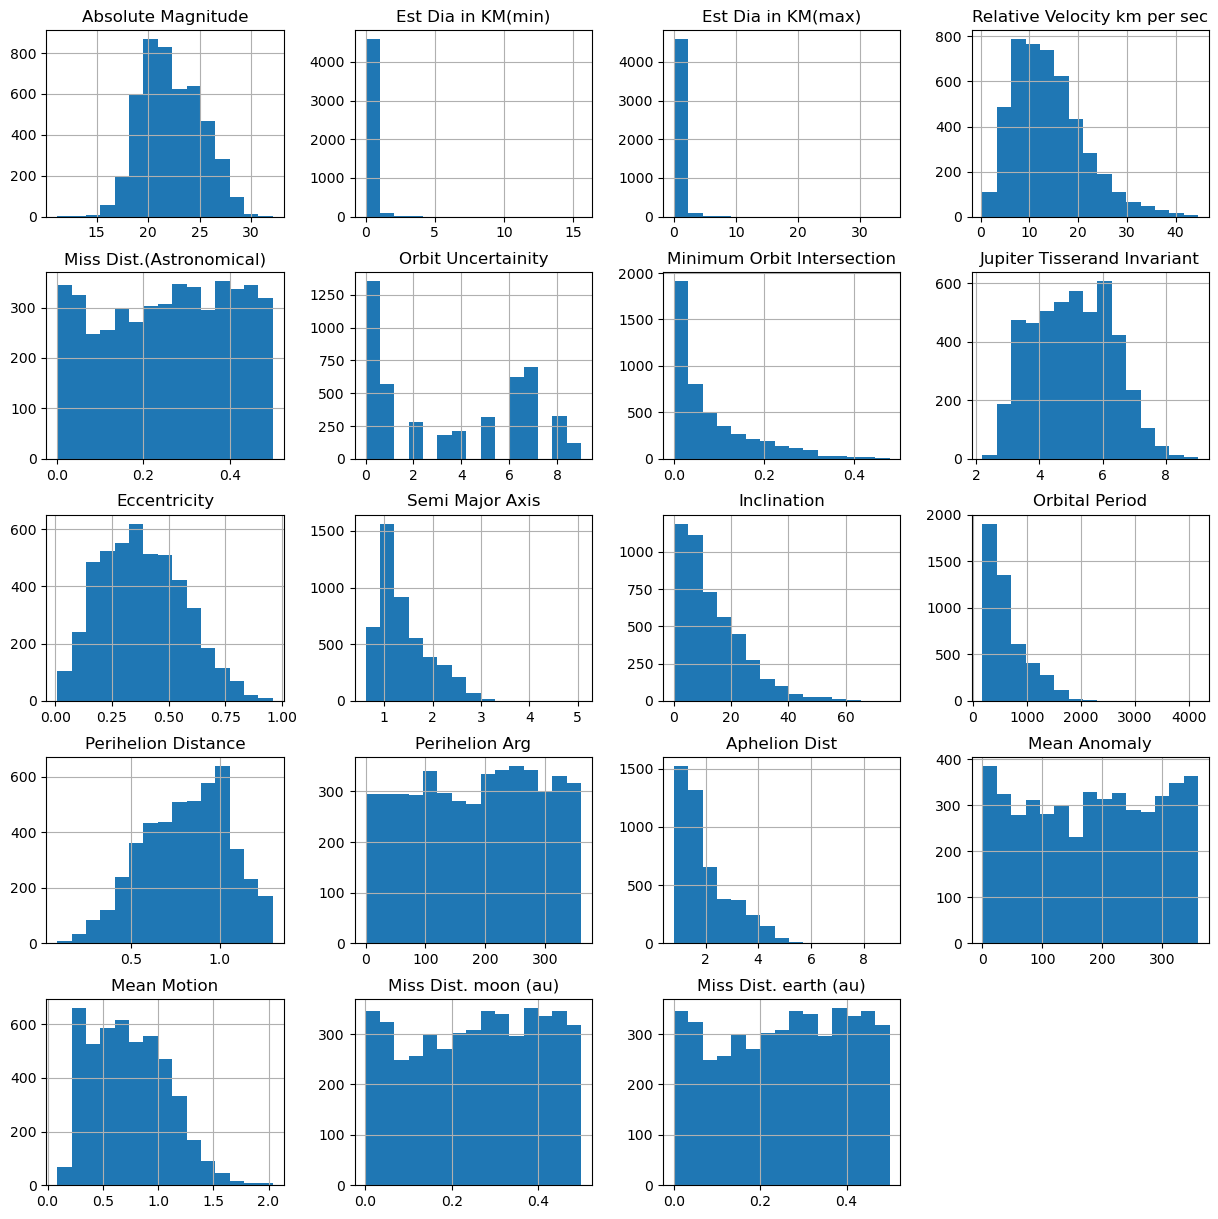

In [25]:
# Histogram
fig, ax = plt.subplots(figsize=(15, 15))
cor_df.hist(ax=ax, bins=15)
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Asteroid Features')

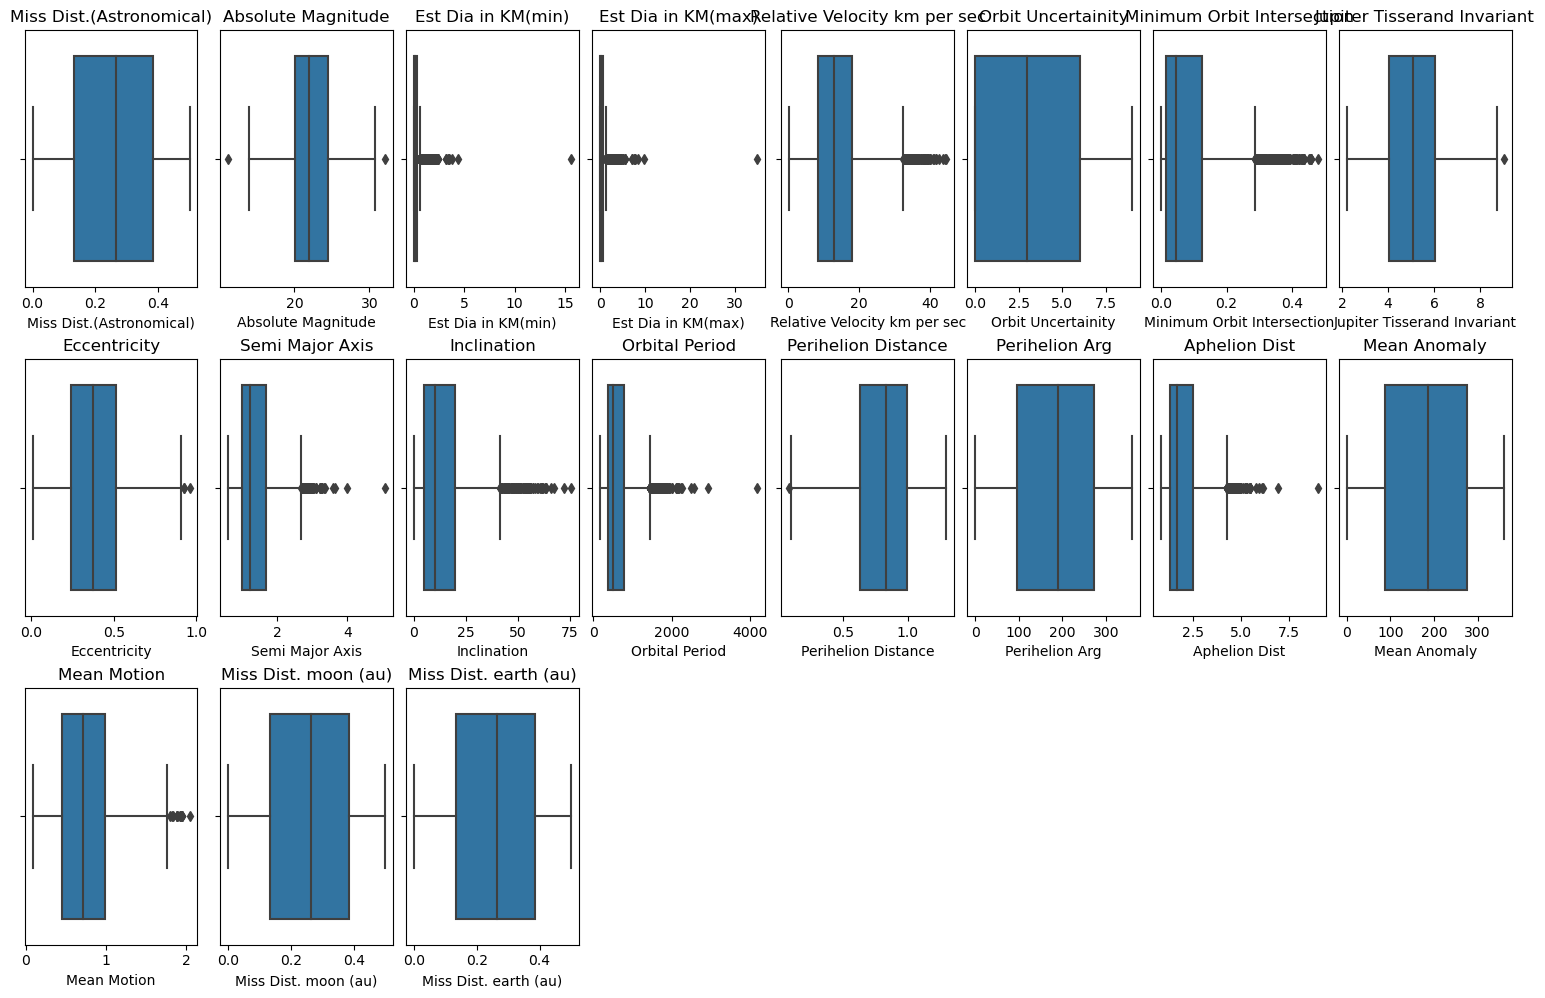

In [26]:
# Boxplots
columns = [
    'Miss Dist.(Astronomical)', 'Absolute Magnitude', 'Est Dia in KM(min)',
    'Est Dia in KM(max)', 'Relative Velocity km per sec', 'Orbit Uncertainity',
    'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant', 'Eccentricity',
    'Semi Major Axis', 'Inclination', 'Orbital Period', 'Perihelion Distance',
    'Perihelion Arg', 'Aphelion Dist', 'Mean Anomaly', 'Mean Motion',
    'Miss Dist. moon (au)', 'Miss Dist. earth (au)'
]

def plot_boxplot(column):
    fig_ax = fig.add_subplot(gs[i, j])
    sns.boxplot(x=cor_df[column], ax=fig_ax)
    fig_ax.set_title(column)

fig = plt.figure(figsize=(15, 15), constrained_layout=True)
gs = fig.add_gridspec(5, 8)

for idx, col in enumerate(columns):
    i, j = divmod(idx, 8)
    plot_boxplot(col)
plt.show()

### Count hazardous objects

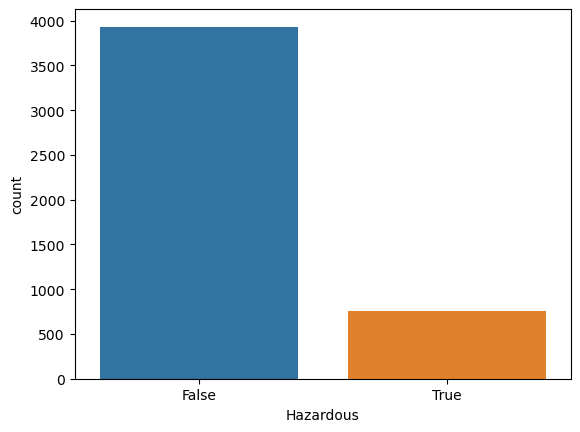

Total number of NEOs: 4687
Number of hazardous NEOs: 755
Percentage of hazardous NEOs: 16.11%


In [36]:
num_hazardous = df['Hazardous'].sum()
num_hazardouss = df['Hazardous'].reset_index()
sns.countplot(data=num_hazardouss,x='Hazardous')
plt.show()
print(f'Total number of NEOs: {len(df)}')
print(f'Number of hazardous NEOs: {num_hazardous}')
print(f"Percentage of hazardous NEOs: {num_hazardous/len(df)*100:.2f}%")

